In [29]:
import json
from py2neo import Graph
from py2neo.data import Node, Relationship

# Need to get authentication working, currently NEO4J_AUTH=none
graph = Graph("bolt://neo4j:7687")

#graph.delete_all()

n_nodes = graph.database.primitive_counts['NumberOfNodeIdsInUse']
n_relationships = graph.database.primitive_counts['NumberOfRelationshipIdsInUse']
print("Connected to graph database with {:,} nodes and {:,} relationships!".format
     (n_nodes, n_relationships))

Connected to graph database with 0 nodes and 315 relationships!


In [30]:
# Constrain one id per Quanta
print("Creating uniqueness constraint (and also index) on Quanta id's...", end=" ", flush=True)
query = """CREATE CONSTRAINT ON (n:Quanta) ASSERT n.id IS UNIQUE;"""
graph.run(query).evaluate()
print("Done.")

Creating uniqueness constraint (and also index) on Quanta id's... Done.


In [34]:
# Create nodes 

# local_data_dir = '/tmp/data/test/'
# neo4j_data_dir = '/import/test/'

local_data_dir = '/tmp/data/test/'
neo4j_data_dir = '/import/test/'

import glob, os
for _, _, files in os.walk(local_data_dir):
    for file in sorted(files):
        if file.endswith('.txt'):
            
#             # Normal query
#             query = """
#             CALL apoc.load.json("file://{}{}") 
#             YIELD value AS q
#             UNWIND q.id AS id
#             MERGE (i:Quanta {{id:q.id}})
#             ON CREATE SET i.abstract=q.abstract, i.refs=q.references, i.title=q.title, 
#                           i.fos=q.fos, i.url=q.url, i.lang=q.lang
#         """.format(neo4j_data_dir, file)
            
            # Iterative query (more efficient)
            print("Importing {}...".format(file), end=" ", flush=True)
            query = """
            CALL apoc.periodic.iterate(
            "CALL apoc.load.json('file://{}{}') YIELD value AS q UNWIND q.id AS id RETURN q", 
            "MERGE (i:Quanta {{id:q.id}}) ON CREATE SET 
            i.refs=q.references, i.year=q.year, i.title=q.title, i.fos=q.fos, i.url=q.url, 
            i.lang=q.lang, i.keywords=q.keywords, i.n_citation=q.n_citation, i.pdf=q.pdf, 
            i.publisher=q.publisher",
            {{batchSize:50000, iterateList:true, parallel:false}});
            """.format(neo4j_data_dir, file)
            #print(query)
            graph.run(query).evaluate()
            print("Done.")

Importing mag_papers_1.txt... Done.
Importing mag_papers_10.txt... Done.
Importing mag_papers_11.txt... Done.
Importing mag_papers_12.txt... Done.
Importing mag_papers_13.txt... Done.
Importing mag_papers_14.txt... Done.
Importing mag_papers_15.txt... Done.
Importing mag_papers_16.txt... Done.
Importing mag_papers_17.txt... Done.
Importing mag_papers_18.txt... Done.
Importing mag_papers_19.txt... Done.
Importing mag_papers_2.txt... Done.
Importing mag_papers_3.txt... Done.
Importing mag_papers_4.txt... Done.
Importing mag_papers_5.txt... Done.
Importing mag_papers_6.txt... Done.
Importing mag_papers_7.txt... Done.
Importing mag_papers_8.txt... Done.
Importing mag_papers_9.txt... Done.


In [35]:
# Add all citations as relationships between Quanta

# # Simple but slow
# query = """
# MATCH (a:Quanta), (b:Quanta)
# WHERE a.id IN b.refs
# CREATE (b)-[:CITES]->(a)
# """

# # Faster but more complex (not benchmarked though)
# query = """
# CALL apoc.periodic.iterate(
#    "MATCH (a:Quanta), (a2:Quanta) WHERE a.id IN a2.refs
#     WITH a, COLLECT(a2) as b
#     RETURN a, b",
#    "UNWIND b AS a2
#     CREATE (a2)-[:CITES]->(a)",
#     {batchSize:5000, parallel:true,iterateList:true}
# """

# # Faster but simple (also not benchmarked)
# query = """
# CALL apoc.periodic.iterate(
#    "MATCH (a:Quanta), (b:Quanta) WHERE ID(a) < ID(b) AND a.id IN b.refs RETURN a, b",
#    "CREATE (b)-[:CITES]->(a)",
#     {batchSize:10000, parallel:true,iterateList:true});
# """

# # Take advantage of indexing performed by constraints
# print("Adding citations...", end=" ", flush=True)
# query = """
# MATCH (b:Quanta)
# UNWIND b.refs AS ref
# MATCH (a:Quanta)
# WHERE a.id = ref
# CREATE (b)-[:CITES]->(a);
# """

# # Take advantage of indexing and also run in batches
# query = """
# CALL apoc.periodic.iterate(
# "MATCH (b:Quanta) 
#  UNWIND b.refs AS ref 
#  MATCH (a:Quanta) 
#  WHERE a.id = ref
#  RETURN a, b",
# "MERGE (b)-[:CITES]->(a)",
#  {batchSize:20000, parallel:false,iterateList:true});
# """

# Fastest: Put more work on thread running in parallel. 
print("Adding citation relationships...", end=" ", flush=True)
query = """
CALL apoc.periodic.iterate(
"MATCH (b:Quanta) UNWIND b.refs AS ref RETURN b, ref",
"MATCH (a:Quanta {id: ref}) CREATE (b)-[:CITES]->(a)",
{batchSize:10000, parallel:false, retries:3})
"""
graph.run(query).evaluate()
print("Done.")


Adding citation relationships... Done.


In [36]:
n_nodes = graph.database.primitive_counts['NumberOfNodeIdsInUse']
n_relationships = graph.database.primitive_counts['NumberOfRelationshipIdsInUse']
print("Created graph database with {:,} nodes and {:,} relationships!".format
     (n_nodes, n_relationships))

Created graph database with 19,999,440 nodes and 13,449,435 relationships!


### Test by running PageRank iteratively (not necessary to build database)

In [37]:
# Run PageRank on each year from 1800 to 1805

import pandas as pd

start_year, end_year = 1900, 2000
dfs = []
for year in range(start_year, end_year+1):

    print("Running PageRank on works from <= {}...".format(year), end=" ")
    query = """
    CALL algo.pageRank(
    'MATCH (p:Quanta) WHERE p.year <= {} RETURN id(p) as id',
    'MATCH (p1:Quanta)-[:CITES]->(p2:Quanta) RETURN id(p1) as source, id(p2) as target',
    {{graph:'cypher', writeProperty:'pageRank', iterations:5, write: true}});
    """.format(year)
    graph.run(query).evaluate()
    
    print("Pulling out and saving results...", end=" ")
    query = """
    MATCH (a:Quanta) 
    WHERE a.year <= {} 
    RETURN id(a), a.title, a.pageRank""".format(year)
    df = graph.run(query).to_data_frame()
    df['year'] = year
    dfs.append(df)
    print("Done.")
    
result = pd.concat(dfs).pivot_table(index='a.title', columns='year', values='a.pageRank')    

Running PageRank on works from <= 1900... Pulling out and saving results... Done.
Running PageRank on works from <= 1901... Pulling out and saving results... Done.
Running PageRank on works from <= 1902... Pulling out and saving results... Done.
Running PageRank on works from <= 1903... Pulling out and saving results... Done.
Running PageRank on works from <= 1904... Pulling out and saving results... Done.
Running PageRank on works from <= 1905... Pulling out and saving results... Done.
Running PageRank on works from <= 1906... Pulling out and saving results... Done.
Running PageRank on works from <= 1907... Pulling out and saving results... Done.
Running PageRank on works from <= 1908... Pulling out and saving results... Done.
Running PageRank on works from <= 1909... Pulling out and saving results... Done.
Running PageRank on works from <= 1910... Pulling out and saving results... Done.
Running PageRank on works from <= 1911... Pulling out and saving results... Done.
Running PageRank

Running PageRank on works from <= 1999... Pulling out and saving results... Done.
Running PageRank on works from <= 2000... Pulling out and saving results... Done.


KeyboardInterrupt: 

In [50]:
result = pd.concat(dfs).pivot_table(index='a.title', columns='year', values='a.pageRank')    

In [51]:
# Write result to CSV
file_path = '/tmp/data/result/impact_20M_{}-{}.csv'.format(start_year, end_year)
print("Writing results to {}...".format(file_path), end=" ")
result.index = result.index.str.replace(",","")
result.to_csv(path_or_buf=file_path, sep=",", header=True, index=True)
print("Done.")

Writing results to /tmp/data/result/impact_20M_1900-2000.csv... Done.


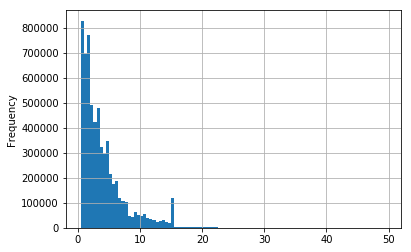

In [90]:
import numpy as np
%matplotlib inline
scores = result.sum(axis=1)
scores.plot.hist(grid=True,bins=[i/2 for i in range(1,100)])

In [189]:
score_threshold = scores.quantile(0.999999)
top_papers = scores.drop(scores[scores.values>=15].index)
print("Considering the top {} (score >= {:.2f}) papers.".format(len(top_papers), score_threshold))

Considering the top 7104387 (score >= 1131.17) papers


In [194]:
import re
word_lists = top_papers.index.to_series().apply(
    lambda x: [w for w in re.compile(r"[A-Za-z']{4,}").findall(x)])
all_words = set()
word_map = {}
for i,v in word_lists.items():
    for w in v:
        all_words.add(w.lower())
        word_map.get(w,[]).append(i)
print("Built set and map of {:,} unique words.".format(len(all_words)))

Built set and map of 1594041 unique words.


In [ ]:
print("Filling {}x{} dataframe...".format(len(all_words),len(result.columns)), end = "")
word_scores = pd.DataFrame(0, index=all_words, columns=result.columns)
for title, ws in word_lists.iteritems():
    print(title)
#     for w in ws:
#         print(w)
#         word_scores.loc[w.lower()] += result.loc[title].va
#         print(word_scores.loc[w.lower()])

Filling 1594041x101 dataframe...! and ? – Storage as tensorial strength
!!~ii~!!iiiiiiiii!iiii~ii!iii!!!i!iii!~ ~~ili!i Selective immunosuppression
!" Polyderivations in Modules with a Divided Grading. Let R be a commutative ring with unit and be an n-graded unitary R-algebra represented in the form
!%@:: a directory of electronic mail addressing & networks
!Adelante! A Cultural Approach to Intermediate Spanish
!Alerta los pueblos! : estudio político-militar del periódo final de la guerra española
!Arriba!: Comunicacion y Cultura
!Backburner! A music scholarship benefit concert
!Cantemos!@@@Rapid Spanish Review@@@Learn to Speak Spanish in Fifteen Days@@@El Abencerraje
!Chicos al fogón!
!Cuidado un Dinosaurio!
!Cuánto les cuesta traducir! Investigación sobre las dificultades de dos grupos universitarios suecos y los comentarios de informates hispanohablantes
!Imaginate! Managing Conversation in Spanish
!Khwa and Menstruation in Narratives of the !Xam Bushmen
!Kung Kinship the Name Relat

"Baznica un valsts buržuāziskajā Latvijā 1920-1940" Z. Balevics Ryga 1964 : [recenzja] / P. Ł.
"Baños de Octavio" (Torre del Mar)
"Bałgarija i Tretijat Reich (1941-1944). Poilitczeski otnoszenija" Witka Toszkowa Sofia 1975 : [recenzja] / Aleksy Deruga.
"Bałtijsko-wołżskij put' " W. B. Wilinbachow "Sowietskaja Archeołogija" nr 3 (1963) : [recenzja] / Eugeniusz Cnotliwy.
"Bałwany" wielickie : ( z badań nad historią techniki górnictwa solnego w Polsce w XVII-XVIII w.) / Antonina Keckowa.
"Be Fruitful And Multiply: - Population Management In Africa On The Eve Of The 21st Centry?: Population Management In Africa Into The next Millennium" Faculty Luncheon Presentation New York University School Of Law.
"Be Quiet" mais modrement : le rle de l'Etat dans la pense conomique de Jeremy Bentham
"Be Single or quit"--Equal Employment Opportunity Law of 1986 and Inflexible Social Attitudes towards Female Employees in Japan
"Be To" as an Expression of Futurity: Human Control Only ?
"Be sober and reason

"Diasporus" - a database for diaspore dispersal-concept and applications in case studies for risk assessment.
"Dichhaptic recognition of shapes and letters in children": Erratum.
"Dictionarius loannis Murmellii vańarum rerum; [Francisci Mymeri] Dictionarium trium linguarum" oprac. Włodzimierz Gruszczyński Kraków 1997 : [recenzja] / Elżbieta Kędelska.
"Dictionary Skills" Is Not a Four-Letter Word.
"Dido y Aeneas" primera ópera inglesa
"Didysis X lietuvos užsienio politykoje. 1926 metų Lietuvos ir Sovietų Sajungos nepuolimo sutarties sudarymo analizė" Algimantas Kasparavičius Vilnius 1996 : [recenzja] / Joanna Januszewska-Jurkiewicz.
"Die "Ostgalizische" bezw. die ukrainische Frage in der Aussenpolitik Polens und der Ententmachte im Jahre 1919" Wassyl Kutschabsky Berlin 1932 : [recenzja] / Z.K.
"Die >>Gesta Hungarorum<< des anonymen Notars : die älteste Darstellung der ungarischen Geschichte" hrsg. von Gabriel Silagi ; unter Mitarbeit von László Veszprémy Sigmaringen 1991 : [recenzja] / 

"FACES AND FEELINGS": A PROJECTIVE TECHNIQUE FOR MEASURING YOUNG CHILDREN'S SELF-ESTEEM"'
"FALSE-POSITIVE" ŒSTROGEN-RECEPTOR ASSAY IN BREAST CANCER
"FAST" AND "SLOW" RESPONSES IN NEPHROPS.
"FAT NECROSIS" OF THE BREAST.
"FATS AND FATTY DEGENERATION": A RESPONSE TO BOOK REVIEWS BY BANCROFT AND CLOWES
"FDR and Stalin. A Not So Grand Alliance 1943-1945" Amos Perlmutter Columbia 1993 : [recenzja] / Bogusław W. Winid.
"FEEDER": ACCEPTABLE OR INSENSITIVE?/Response
"FIN": A new deconvolution algorithm brings "CACAO" beyond expectations
"FISCAL BALANCE DURING INFLATION DISINFLATION AND INMIGRATION: POLICY LESSONS"*/
"FLIGHT OF COLOURS" IN MULTIPLE SCLEROSIS
"FLOATING TEETH" IN A FAMILIAL DISEASE ASSOCIATED WITH DYSPROTEINEMIA THAT IS NOT HAND-SCHUELLER-CHRISTIAN DISEASE.
"FLUESSIGKEITSINJEKTOR DER DRUECKER-BAUART"
"FLUESSIGKRISTALLINE PHASEN AUFWEISENDE ZUSAMMENSETZUNGEN AUF BASIS CYCLISCHER ORGANOPOLYSILOXANE IHRE HERSTELLUNG UND DEREN VERWENDUNG"
"FOERDERVORRICHTUNG FUER EINE BOGEN-ROTATIONSD

"Individuelle Modernisierung" - zur Logik biographischer Konstruktion in modernisierten modernen Gesellschaften
"Industrialization and Women's Work: A New Perspective on the Mill-Worker Experience in Ante-bellum Lowell Massachusetts."
"Industrialization Labor Controls and Democracy:" A Rejoinder
"Industrious in Their Habits: Rediscovering the World of Work"
"Indyjski ruch nacjonalistyczny w czasie drugiej wojny światowej" Ewa Toczek "Dzieje Najnowsze" 1985 no 1 : [recenzja] / E. C. K.
"Inextricable Disordered Ranges": Mary Austin's Ecofeminist Explorations in Lost Borders
"Infant formula distribution and advertising in pregnancy: a hospital survey".
"Información Arqueológica" Boletín Informativo del Instituto de Prehistoria y Arqueología de la Diputación Provincial de Barcelona
"Informacja - odbicie - twórczość" Todor Pawłow Warszawa 1984 : [recenzja].
"Informacja i propaganda w Polsce za Zygmunta III" Urszula Augustyniak Warszawa 1981 : [recenzja] / Kazimierz Maliszewski.
"Information

"Las galeras de España". La defensa del Estrecho en época de Felipe II: aproximación a través de la correspondencia del Consejo de Guerra con el conde de Santa Gadea (1584-1597)
"Las grandes puertas" de Fayad Jamís
"Las meninas" como obra maestra
"Las olas" como obra de arte: algunos usos del ritmo y la composición
"Las paces de los reyes" y "La judía de Toledo" en Lope de Vega: Una aproximación al lenguaje equívoca
"Las voces perdidas": silencio y recuerdo en Memoria de la melancolía de María Teresa de León
"Lascio tutto così -"; "Buio vivo corona del respiro"; "...come un orto di mani"; "Mangiando nella mente"; "mia madre è l'opera"
"Lassen Sie ihn doch Geige lernen" : Erinnerungen
"Lata szkolne Z. Krasińskiego. Nowe materyały" Józef Kallenbach Lwów 1907 : [recenzja] / Wiktor Hahn.
"Lata wojny trzynastoletniej w "Rocznikach czyli kronikach" inaczej "Historii polskiej" Jana Długosza (1454-1466) t. I Komentarz krytyczny" oprac. Stefan Kuczyński K. Górski W. Dworzaczek W. Madyda G. Mała

"Neolityczne zespoły pracowniane z kopalni krzemienia w Sąspowie" A. Dzieduszycka-Machnikowa J. Lech Wrocław-Warszawa-Kraków-Gdańsk 1976 : [recenzja] / Bogdan Balcer.
"Neostam" Stíbamine Glucoside in the Treatment of Kala Azar. (A Preliminary Report.).
"Neotorularia torulosa" (Desf.) Edge & Léonard ("Cruciferae") en la Península Ibérica
"Nestgeur is belangrijk"[verslag 60 jaar Algemene Nederlandse Imkersvereniging] (Verenigingsnieuws ANI).
"Nettowohlfahrtsindikator": ein japanischer Ansatz
"Neue Bücher und Aufsatze zum Bibliotheks- und Buchswesen" Günther Reichert "Zentralblatt für Bibliotekswesen" 69 (1955) s. 474-487 : [recenzja] / G. L.
"Neue Funde des Pferdes aus dem Keltischen Oppidum von Manching" Klaus G. Frank "Studien an vor- und frühgeschichtlichen Tierresten Baterns" z. 13 (1962) : [recenzja] / Marian Kubasiewicz.
"Neue Sachlichkeit - Malerei Graphik und Photographie in Deutschland 1919-1933" Sergiusz Michalski Köln 1992 : [recenzja] / Joanna Sosnowska.
"Neue Studien zum Eid

"Powietrze dźwięk i światło" / P. M. Lubiński.
"Powieści biograficzne Jana Zachariasiewicza" Czesław Kłak Przemyśl 1969 : [recenzja] / J.P.
"Powieści historyczne Henryka Rzewuskiego" Zygmunt Szweykowski Warszawa 1922 : [recenzja] / Konstanty Wojciechowski.
"Powieści historyczne J. I. Kraszewskiego" Wincenty Danek Warszawa 1966 : [recenzja] / Marceli Kosman.
"Powieści historyczne J. I. Kraszewskiego" Wincenty Danek Warszawa 1966 Ludowa Spółdzielnia Wydawnicza s. 268 + 10 wklejek ilustr.: [recenzja] / Mieczysław Inglot.
"Powieść a dziennik intymny" Michał Głowiński Wrocław-Warszawa-Kraków-Gdańsk 1971 : [recenzja] / M. G.
"Powieść i miłość - "Pamela" Jan Watt "Pamiętnik Literacki" R.LXI (1970) : [recenzja] / T.K.
"Powinności feudalne chłopów na Mazowszu od XIV do początków XVI wieku (w dobrach monarszych i kościelnych)" Hubert Wajs Warszawa-Wrocław 1986 : [recenzja] / Dariusz Główka.
"Powiązania koncernowe banków państwowych w Polsce międzywojennej" Jerzy Gołębiowski [w:] "Studia Historyc

"Si haulte architecture" : the design of Scève's Délie
"Si las mujeres mandasen...": Diario 1995
"Si nulla esset in terra anima" : Johannes Keplers Seelenlehre als Grundlage seines Wissenschaftsverständnisses
"Si se sabe sentir se sabe decir": Cervantes sentido por Trapiello
"Si tu me fais l'honneur d'un p'tit téléphone demain matin ben je suis contente"
"Si volviera el verano" un texto de Adamov
"Sibirskaja dieriewnia na puti k socyalizmu (Socyalno-ekonomiczeskoje razwitije sibirskoj dieriewni w gody socyalisticzeskoj riekonstrukcyi narodnogo choziajstwa. 1926-1937 gg.)" N. Ja. Guszczin Nowosibirsk 1973 : [recenzja] / R. W.
"Sibirskije goroda XVII - naczała XX wieka" Nowosibirsk 1981 : [recenzja] / Andrzej Wyrobisz.
"Sic in Amore Furens": Painting as Poetic Theory in the Early Renaissance
"Sidabras kaip vertes matas I m.e. tukstantmečio Lietuvoje" L. Nakaite "Lietuvos TSR Mokslu Akademijos Darbai" Serija A 1 (20) 1966 : [recenzja] / P. de Laval.
"Side-by-Side" Profile of Proposed Chan

"Strajki szkolne na Górnym Śląsku w latach 1906 i 1920" Teodor Musioł Warszawa-Wrocław 1970 : [recenzja] / Henryk Dobrowolski.
"Stralsund 1600-1630 : eine Hansestadt in der Krise und im euröpaischen Konflikt" Herbert Langer Weimar 1970 : [recenzja] / Bogdan Wachowiak.
"Strany i narody: Proischożdienije nazwanij" R.A. Agiejewa Moskwa 1990 : [recenzja] / Bożena Hrynkiewicz-Adamskich.
"Strategic governance:" the wrong questions?
"Stratified" old [spoil] pile S. Seas Plantation
"Straty kulturalne Warszawy I" pod red. Władysława Tomkiewicza Warszawa 1948 : [recenzja] / J. L.
"Strawberry" gingival hyperplasia: a pathognomonic mucocutaneous finding in Wegener granulomatosis.
"Straż praw" Józef Wojakowski Warszawa 1982 : [recenzja] / Aleksander Czaja.
"Strażnica Zachodnia" w latach 1922-1939 : (przyczynek do historii prasy poznańskiej) / Tadeusz Bartkowiak.
"Streaking Leukocyte Factor" Arthritis and Pyoderma Gangrenosum
"Streaming" in portal vein. Its effect on the spread of metastases to the 

"Thoughts on advanced education" or "advanced education is for you".
"Thoughts" about Preserving and Empowering Families through Co-Parenting Partnerships.
"Thousands of our men are getting practically nothing at all to do" : Public Works Relief Programs in Regina and Saskatoon 1929-1940
"Thrax" "Dytinos" "Katarráktes"
"Three Fayûm Papyri" John Barns "Chronique d'Egypte" no 48 1949 : [recenzja] / Raphael Taubenschlag.
"Three Interpretations of the Universe" and "God: A Cosmic Philosophy of Religion"
"Three Lessons for Monetary Policy in a Low Inflation Era" by David Reifschneider and John Williams
"Three Women One Struggle": Anthropology Performance and Pedagogy
"Three primaries" method in pushing family planning ahead.
"Throne and Altar: The Political and Religious Thought of Joseph de Maistre" by Richard Allen Lebrun
"Through the Looking Glass": Divine Madness in the Hindu Religious Tradition
"Through-space" spin–spin coupling between thallium and hydrogen in o-alkylphenylthallium co

"Zagadnienie historii filozofii" Stefan Świeżawski Warszawa 1966 : [recenzja] / Karol Górski.
"Zagadnienie identyfikacji niewolników w sztuce greckiej" Jerzy Wielowiejski.
"Zagadnienie reformy tradycyjnej notacji muzycznej" J. Habela Katowice 1963 : [recenzja] / Zofia Helman.
"Zagadnienie śmierci w kulturze Rzeczypospolitej czasów saskich" Bogdan Rok Wrocław 1991 : [recenzja] / Bożena Płonka-Syroka.
"Zagraniczna edukacja Radziwiłłów od początku XVI do połowy XVII wieku" Marian Chachaj Lublin 1995 ss. 171 : [recenzja] / Bogdan Rok.
"Zagłada i pamięć. Doświadczenie Holocaustu i jego konsekwencje opisane na podstawie relacji autobiograficznych" Barbara Engelking Warszawa 1994 : [recenzja] / Bronisław Gołębiowski.
"Zagłada polskich Kresów. Ziemiaństwo polskie na Kresach Północno-Wschodnich Rzeczypospolitej pod okupacją sowiecką 1939-1941. Studium z dziejów zagłady dawnego narodu politycznego" Krzysztof Jasiewicz Warszawa 1997 : [recenzja] / Tadeusz Epsztein Daniel Boćkowski.
"Zakłady města

"災害かくし"をやめさせた川重神戸工場での経験 (産業別シリ-ズ-7-造船労働者)
"無関心層"への切りこみを (73春闘の総括(特集)) -- (73春闘と青年労働者--労組青年部・青対部からの報告)
"牛歩の社会党"に高まる批判--「集団辞職」の強硬策も裏目に(政界メモ)
"牛蠅 HYPODERMA SP.ノ食道粘膜下寄生時代ニ於ケル蛆毒素""HYPODERMATOTOXIN""ノ研究I.":蛆毒素ノ血液凝固ニ及ボス作用
"牧草と環境"に寄せての草地生態系論 (畜産と環境(特集)) -- (牧草編)
"物"と"もの"--荻生徂徠と本居宣長の所説を通して (ものとこと )
"物ごとの最初"ものがたり--コーヒー茶紅茶タバコ
"物ごとの最初"ものがたり--文字の始め・粘土板・古代文字・ローマ字
"物ごとの最初"ものがたり--洋風建築・丸の内・銀座・錦絵
"物価値上げ"と"買占め"--世界を荒す日本商社
"物性研究"創刊(第I部:「物性論研究」及び「物性研究」編集者の回想記 「物性研究」10周年記念)
"物語ること"と"包むこと"--心理的治癒と成長にかかわる要因について
"物質への挑戦"のシリ-ズを始めるにあたって ("物質への挑戦"シリ-ズ-1-)
"物質への挑戦"シリ-ズ アモルファス半導体--材料研究の新しい動き
"物質への挑戦"シリ-ズ--人工不働態皮膜
"物質への挑戦"シリ-ズ--超高速LSIを狙うGaAs結晶
"特発性"心電図異常を示す若年成人の糖尿病発現率 とくにブドウ糖負荷試験とタバコ皮内反応との関係について
"犯罪汚染"が進む日本社会(時の話題)
"独断と偏見"の流行歌(はやりうた)50年私史-16-フォ-クの変質と「うたの里」
"独断と偏見"の流行歌(はやりうた)50年私史-20-カラオケブ-ムと東南アジア輸入歌手
"独断と偏見"の流行歌(はやりうた)50年私史-21-"ピンク・レディ旋風"と阿久悠
"独立割当問題"の解法と回路の複雑度決定問題への応用(技術談話室)
"王林"/M.26に発生したロゼット状生育障害
"班〓〓怨"のモチ-フの展開について--王昌齢の「長信秋詞」其二を中心に
"現代は無責任時代か"に応う (責任--消えたこの文化価値について )
"現代化"に進む中国軍 (中国近代化の諸相 )
"現在株価1万円"の条件は「20%増益を2

''A'' - You're Adorable : The Alphabet Song
''Absolute universal instability'' is not universal
''Adonis'' vs. ''The queen and huntress'': transforming the myth of the woman artist in the later novels of Caroline Gordon
''Agrolistic'' transformation of plant cells: Integration of T-strands generated in planta
''Anomalous'' behavior of the profile of the nu 1 band of CH4 as a result of varying the gas density
''Anomalous'' effects in the appearance of a detonation wave at a free surface
''As Sparrows Eagles Or the Hare the Lion'' : Macbeth I幕ii場における Ambivalence の一考察
''BROKEN SU(3)'' SYMMETRY IN STRONG-COUPLING THEORY.
''Biostack-2'' experiment. Report 2. Inactivation of cells in yeast colonies under the influence of heavy ions of galactic cosmic radiation. [Saccharomyces ellipsoides]
''By-pass'' fémoro-tibial en el tratamiento de la isquemia grave de los miembros inferiores
''CARAMEL'' A uranium-oxide-sheeted fuel for water reactors
''Cavities'' in the intergalactic medium
''Cold Comfor

'No Taxation without Representation': The Assembly of Notables of 1787 and Political Ideology in France
'No Uranium. No more Hiroshimas' badge c1969 to 1975
'No longer nineteen'. A review of Vietnam veterans in everyday practice.
'No longer will we call ourselves Catholics in Wales but Welsh Catholics' : Roman Catholicism the Welsh language and Welsh national identity in the Twentieth Century /
'No matter how good the concept if it is not properly conveyed to those who will decide on its future then it will remain a concept and not a product'
'No more pivotal election' in 1996. State Supreme Court holds liability reform in its hands.
'No necessary connection with homework': gender and sweated labour 1840-1909.: gender and sweated labour 1840-1909.
'No one will know' attitude causes unnecessary risks.
'No secret' to complex process of bill analysis.
'No sé hablar so no veo unos ojos que me miran': En torno a la narrativa de Carmen Martín Gaite
'No'라고 말할 수 있는 한국
'Nobody Cares: The Challe

(1-(25-dimethoxy-4 iodophenyl)-2-aminopropane)-induced head-twitches in the rat are mediated by 5-hydroxytryptamine (5-HT) 2A receptors: modulation by novel 5-HT2A/2C antagonists D1 antagonists and 5-HT1A agonists.
(1-1)-Linked C-Disaccharides Synthesis of Bis(-D-Galactopyranosyl)Methane
(1-14) 鋼の回転曲げ疲労過程で発生する歪エネルギ変化に及ぼす温度変化の影響について
(1-2) 線材の重複荷重ねじり塑性疲労について
(1-22) 低炭素鋼の低サイクル疲労寿命に及ぼす温度及び繰返し速度の影響 : き裂形態と下部組織について
(1-24) 炭素鋼の疲労き裂伝ぱ挙動に及ぼす炭素含有量の影響
(1-40) 軟鋼・高張力鋼クラッド板の疲労強度について
(1-6) タフトライド処理鋼の疲れ破壊に関する研究 : 疲労限の推定について
(1->3)-β-glucans in plant host-pathogen interactions.
(1-Adamantanethio)pyridines and tetrahydropyridines from the reaction of 1-adamantanethiol with pyridine I-oxide in acetic anhydride†
(1-Alkyl-5-nitro-imidazolyl-2-alkyl)-heteroaryl compounds and process for their manufacture
(1-Aziridinyl)cyclotriphosphaza-135-trienes
(1-BROMO-1(BROMOMETHYL)-3 3 3-TRICHLOROPROPYL) BENZENE COMPOUNDS
(1-Beta-mercapto-betabeta-diethylpropionic acid)-8-lysine-vasopressin a potent inhibitor of 8-lys

(3S)-3-Hydroxyquinidine the Major Biotransformation Product of Quinidine. Synthesis and Conformational Studies. X-Ray Molecular Structure of (3S)-3-Hydroxyquinidine Methanesulfonate.
(3aR*6aS*)-55-Diphenyl-233a466a-hexahydrosilolano[34-b]furan-2-one: A New Fused g-Butyrolactone
(3～11)ガス状炭化水素の合成に關する研究(第7～15報)
(3～5)撫順産緑色頁岩の利用と頁岩油の精製に關する研究(第10～12報)
(4 + 2)Cycloadditions of Silylated and non Silylated Thiones (II) with Vinyl Trimethylsilyl Ketone (I). Novel Synthesis of 4H-13-Oxathiins ( III).
(4) Auto-oxidative Damage in SLE RA and Behcet's Disease
(4) DNA 塩基配列の相同性比較による植物病原糸状菌の分類に関する研究 : 第1報 Alternaria 属菌の遺伝的類縁性 (昭和62年度日本植物病理学会大会講演要旨)
(4) Penicillin 抗原について( B〔I〕: 皮膚反応における抗原の検討)
(4) Protein-calory Malnutrition in the Infant and Pre-school Child
(4) Rigorous Treatment of the Damping Theory for Coupled Systems in contact with Reservoirs : Parametric Amplifier and Laser
(4) World copper survey: (1980) 210 pp. £18 (postage and packing not included)
(4) アルカリ水熱法によるレアメタルスクラップのリサイクリング(主題 : 二次資源処理の

(Ed. Woord vooraf)-
(Editor) Plant-Animal Interactions (textbook)
(Editorial) Povidone-iodine and wound infection
(Editorial) Special Letters Edition: First Science with the VLT
(Editorial) Where Are the Fathers in the Literature? Pretty Likely Right Here in Families in Society
(Editorial) “Different” Families
(Education); *Community Colleges; *Course Descriptions; *Curriculum Development; Decision Making; Educational Planning; Higher Education; State Aid; *Technical Institutes; *Transfer Policy; Two Year Colleges
(Eighth Edition) Gmelin Handbook of Inorganic and Organometallic Chemistry Supplement Volume B3 Springer-Verlag Dordrecht Netherlands (1995) ISBN 3-54093719-6.
(Electron-ion cross beam experiments and ion-atom collisions Louvain-la-Neuve Belgium Paris France Utrecht the Netherlands and Groeningen the Netherlands April 30--May 28 1989): Foreign trip report
(Electronic version prepared by D. Sutton) Catalogue of Diagnostic X-ray Spectra and Other Data (IPEM Report 78) £20. In: 

(±)-3-[4'-(NN-dimethylamino)cinnamyl]benzazepine analogs : Novel dopamine D1 receptor antagonists
(±)-4-(2-Chlorophenyl)」-2-[2-(4-isobutylphenyl)ethyl]-69-dimethyl-6H-thieno[32-f] [124]triazolo[43-a] [14]diazepine(Y-24180)のイヌにおける12ヵ月間反復経口投与毒性試験および回復性試験
(±)-Anti-benzo[a]pyrene diolepoxide-induced p53 accumulation in isolated human peripheral blood lymphocytes
(±)-Byak-angelicol. A natural furanocoumarin
(±)-Norphenylephrine hydrochloride (m-octopamine hydrochloride) C8H12NO2+.Cl−
(±)-Phoracantholid I via the caesium carbonate-promoted ring closures of the methanesulphonate of 9-hydroxydecanoic acid
(±)-Severzinine from Corydalis flabellata: interpretation of NMR spectra
(±)-threo-3-Hydroxy-23-diphenylpropanoic Acid Dimethylamide
(±)-trans-7-azido- und 7-phthalimido-12-secoceph-3-em-4-carbonsäureester aus 3-substituierten 2-isothiocyanato-acrylsäureestern
(±)-trans-N'O-Cyclohexylidene-N-(2-hydroxycyclohexyl)guanidinium p-toluenesulfonate
(±)-エボドンの簡便な合成(ノ-ト)
(±)-ラリシレジノ-ルの合成〔英文〕
(±)3-Deaza

-487- REGRESSION OF CARDIAC HYPERTROPHY AND CHANGES OF CARDIAC α_1 AND β RECEPTORS WITH ANTIHYPERTENSIVE THERAPY IN SHR
-49-CLOSE CORRELATIONS OF MYOCARDIAL OXYGEN DELIVERY AND METABOLIC CHANGES TO EARLY CONTRACTILE DETERIORATION
-493- CHANGES IN CSF AND SERUM SODIUM CONCENTRATION AND BLOOD PRESSURE IN DOCA-SALT HYPERTENSIVE RATS
-5- EARLY CORONARY REPERFUSION BY PTCA IN CARDIOGENIC SHOCK AFTER ACUTE MYOCARDIAL INFARCTION (AMI) : PTCA : FREE COMMUNICATIONS(I) : PROCEEDINGS OF THE 51th ANNUAL SCIENTIFIC MEETING OF THE JAPANESE CIRCULATION SOCIETY
-50- ELECTROPHYSIOLOGIC ASSESSMENT OF THE EFFECTS OF INTRAVENOUS BEPRIDIL ON CONDUCTION AND REFRACTORINESS IN THE HUMAN HEART : Arrhythmias : FREE COMMUNICATIONS(I) : PROCEEDINGS OF THE 51th ANNUAL SCIENTIFIC MEETING OF THE JAPANESE CIRCULATION SOCIETY
-503-HOSPITAL VISITING RATE OF ACUTE MYOCARDIAL INFARCTION DEATH AND SUDDEN DEATH IN URBAN AREA : Myocardial Infarction : FREE COMMUNICATIONS(II) : PROCEEDINGS OF THE 53th ANNUAL SCIENTIFIC MEETI

03 Priority According to His Word
03 The Need of the Hour
03 The Position of the Jew
03 The Power of Divine Healing.
03 The Scriptural Statement Concerning the Baptism in the Spirit (Chapters XIII-XVI)
03 Thomas Binney in South Australia 1858-1859
03 心臓カテーテル検査室における電気的安全(第31回中部部会)
03 第2報 : 小肝細胞癌におけるPIVKA-II測定の臨床的意義(第32回中部部会)
03-01-1973 Justice Douglas Dissenting
03-07-2000 Speaking at a presentation of the Tipperary International Peace Award to Senator George Mitchell
03.O.04 Bioaerosol collection and growth on filters used for building ventilation
030 3歳児のままごと遊び(3) : ままごとコーナーにおける物とのかかわり
030 乳児期の家庭環境と4歳時の知的発達(乳児期の母子相互交渉特定テーマ)
030 函館市における地震被害の予測とその活用について(地震防災講演研究論文)
030 子ども同士のかかわりのあり方(1) : 特定の子どもとつながること
030 非適合歪エネルギーを考慮したFEMモデル : 板曲げ問題への適用と検証(構成則・無梁板・FEM建築構造)
0302 Application for Pension [and Related Records]
0302 実験的ウイルス性心筋炎における心筋内ウイルス核酸ならびに蛋白の発現様式 : oligonucleotide probeとペプチド抗体を用いた超微形態学的検索
0307 急性心筋梗塞症(AMI)での左心機能の回復に 心筋梗塞の隣接領域および遠隔領域の局所心機能の回復も関連している : 定量的心拍同期SPECT(QGS)を用いた左前下行枝症例での検討
0

1 Differences in SLAP lesion between volleyball and baseball players
1 Diplomatische Transkription des Textes der Sprüche der sieben Weisen aus dem Codex Vrat. Rhed. Gr. 12 ff . 138r 1. 7- 138v 1. 11
1 Double Mesh Method for Efficient Finite Difference Calculations
1 Dress and the Social Control of the Body
1 Enzymes of the Fructose 6-Phosphate-Fructose 1 6-Bisphosphate Substrate Cycle
1 Epithelial Barrier to Acid: Studies with Isolated Membrane Vesicles and Cultured Epithelial Cells
1 Estonia on the Eve of Independence: Overview of the Study
1 Evaluation of the 3-D Optical Interconnection Module of the Sliding Banvan Arc
1 Evidence-based obstetrics and gynaecology
1 Federal Initiatives to Transfer Technology to Private Industry
1 Field Delaying Device of TV Signal Using Flexible-Disk Magnetic Recorder
1 Field studies on the flow and composition of storm sewage
1 Fifty Ways to Save Your Budget Reduced Cost Systems Engineering Process Improvement
1 Freezing the Frame: Dress and Ethnicit

110-フェナトロリン及びその誘導体の金属錯体の合成と性質
110-フェナントロリン-鉄 (II)-クロラニル酸抽出法による硫酸イオンの間接吸光光度定量法:金属キレート陽イオンによる陰イオンの溶媒抽出吸光光度定量法 (第31報)
110-フェナントロリンによる鉄の定量における還元剤としてチオピリンの利用:チオピラゾロン誘導体の分析化学的研究(第6報)
110-菲啰啉-1-氧化物及乙酸与稀土的双核配合物
1100MWe原子力発電所用6900Vメタルクラッドスイッチギアの耐震設計
110‐フェナントロリンを含む大環状化合物ニッケル錯体の合成と核酸との反応
110—双（1′—苯基—3′—甲基—5′—氧代吡唑—4′—基）癸二酮—（110）？…
110—蒽醌类的分析应用
111-Dihydroxy-tetracenchinon-(512)
1144 niños con diarrea aguda hidratados por vía oral con solución de 90 mmol/l de sodio
11`—（六甲基三硅撑）双环戊二烯基二（对氯苯氧基）钛...
11—二对甲苯基乙烷的研制
11—二氟乙烷制备动力学特性研究
11—二烷基—4—（3—溴丙酰基）—哌嗪溴化物的合成及生物活性研究
11‘-Bis(dimethylvinylsilyl)ferrocene as a Two-Directional Core for the Construction of Homo- and Heterometallic Systems
11‘—二（N—萘甲酰腙乙基）二茂铁与一些过渡金属的配合物研究
11‘—双取代二茂铁为配体的配合物的研究：VI.含有dppf配体的∏—键合...
11’-联-2-萘胺的合成新方法
11′-Bis(NN-dimethylamino)ferrocene11′-bis(NN-dimethylamino) cobaltocenium hexafluorophosphate and 11′-bis(NN-dimethylamino)titanocene dichloride. Crystal structure of 11′-bis(NN-dimethylamino)titanocene dichloride
11′-Disubstituierte Ti

1-2 経営課題解決のためのTQMの構造(第29回年次大会)
1-2 随従眼球運動と予測機能
1-2 霧島山東麓地帯における黒ボク畑土壌の物理的性質(1.土壌物理)
1-2 香りのイメージ解析 : 香りコントローラ用香料の嗜好解析(第45回研究発表会-中部支部第11回-)
1-2 高専における常微分方程式の取扱いについて : 数学嫌いを減らすために
1-2-1. 調整過程における総義歯の3次元的寸法変化 : 第1報 人工歯の位置ならびに義歯床表面の形状について
1-2-10. 歯肉溝浸出液の臨床的指標とそのタンパク分画との関連性( 第77回日本補綴歯科学会学術大会講演要旨)
1-2-11. 陶材焼付用金属の非破壊的応力解析 (昭和60年度日本補綴歯科学会東北・北海道支部会学術大会)
1-2-14. 支台歯の歯肉滲出液量とpHの変動 (第74回日本補綴歯科学会学術大会講演要旨)
1-2-15. ラット耳下腺の交感神経性α_1-受容体の分泌機能 特に加齢差と性差について( 第77回日本補綴歯科学会学術大会講演要旨)
1-2-15. 上顎全部床義歯口蓋前部の形態 : 特にS状隆起と調音に関する研究
1-2-17. 光重合を応用した表面処理法による義歯床粘膜面の寸法変化について
1-2-17. 有床義歯の研磨に関する研究第1報 : 研磨が床の曲げ強さに及ぼす影響について (昭和60年度日本補綴歯科学会東北・北海道支部会学術大会)
1-2-18. 義歯安定剤の基礎的および臨床的検討 : 臨床的性質について (昭和60年度日本補綴歯科学会東北・北海道支部会学術大会)
1-2-2. 臼歯部人工歯の選択基準について
1-2-20. 義歯床の形態がひずみ分布におよぼす影響について( 第75回日本補綴歯科学会学術大会講演要旨)
1-2-21. リン酸カルシウム系結晶化ガラス(CPCC)機械的性質について (昭和60年度日本補綴歯科学会東北・北海道支部会学術大会)
1-2-22. 既製ポストを応用したメタルコアに関する基礎的研究(第2報)( 第76回日本補綴歯科学会学術大会講演要旨)
1-2-24. 電解式組織血流計による顎粘膜血流動態に関する基礎的検討( 第75回日本補綴歯科学会学術大会講演要旨)
1-2-3 97 for Windows for Dummies
1-2-3 98 Lo

1. Formalist Legal Science
1. Formation of C–C Bonds: 1.1 Formation of C–C Bonds by Alkylation Reactions (XIII)
1. Formation of C–C Bonds: 1.1 Formation of C–C Bonds by Alkylation Reactions (XIX)
1. Forschung und Dokumentation
1. Forschungsstand und Aufgabenstellung
1. Fort de Moḥammad 'Ali
1. Fortschritte der Technik in der Colonchirurgie Progress in colon surgery
1. Fortschritte in der Diagnostik chirurgischer Krankheitsbilder
1. Fragestellungen und Untersuchungsansätze
1. Frauenreisen als literaturwissenschaftliches Thema
1. From hospital to asylum
1. From the Prairies to Oxford 1917-1938
1. Fullkörpersäulen - Theorien und Praxis. 2. Füllkörpersäulen - Handbuch. Von R. Beck. Eigenverlag Ludwigshafen/Rh. 1987. 1. 200 S. geb. DM 53-; 2. 50 S. geb. DM 27-
1. Fundamentals of the Electromagnetic Method
1. Fünf Jahre ohne Bomben
1. Für eine beziehungsreiche Architektur! Ein behutsames Manifest
1. GENETICS: Abnormalities of the Sex Chromosome Complement in Man.
1. GROWTH HORMINE (CH) LEVEL

1.2.8 The Celestial Ephemeris Pole
1.2/4.4mm 세심동축케이블
1.21 – Triethylamine
1.23 – Mechanics of Textile Composites
1.24 Gb/s 40 km optical code division multiplexing transmission by using spectral bipolar coding of broadband incoherent light
1.25 Gbps CMOS 數位發射機
1.25 Micron injection logic technology
1.25-Gb/s wideband LED driver design using active matching techniques
1.26 μm intersubband transitions in In0.3Ga0.7As/AlAs quantum wells
1.27 Micrometers Receiver Development.
1.27 mu m atomic argon laser parameters in fission-fragment excited He/Ar and He/Ne/Ar gas mixtures
1.27μm吸收型部分增益耦合MQW—DFB激光器
1.29 – Four-membered Rings with One Boron or Other Atom
1.2: Out There Having Fun in the Warm California Sun
1.2kbps Fblpc Vocoder With Applications In Phone-to-phone Over Internet
1.2‐Benzo‐5.6‐dimethylcalicen
1.2——二氯乙烷中毒23例临床分析
1.2—聚丁二烯／顺丁橡胶共混胶的性能研究
1.2人の無限責任社員がいる合資会社において1人の無限責任社員が単独で会社を代表して提起した訴訟の効力2.右合資会社において1人の無限責任社員が他の無限責任社員の同意を得ずにした会社資産の処分行為の効力--東京高裁判決平成7.6.29(金融商事判例研究)
1.2工業研究(1.一般)
1.2

10 Gbit/s penalty-free transmission over 48 km using 1.3-/spl mu/m wavelength electroabsorption modulated lasers (EML) for metro-loop transmission link
10 Gbit/s silicon bipolar optical receiver and regenerator
10 Gbit/s soliton transmission over standard fibre
10 Gbit/s timing recovery circuit using dielectric resonator and active bandpass filters
10 Gbit/s transmission experiment over 793.2 km G.652 fiber
10 Gbit/s 1200 km error-free soliton data transmission using erbium-doped fibre amplifiers
10 Gbit/s 50 km dispersive fibre transmission experiment using strained multiquantum-well DFB laser diode
10 Gbit/s-1200km single-pass soliton data transmission using erbium-doped fiber amplifiers
10 Gbit/s-Soliton Transmission over 5700 km in Dispersion Compensated Standard Fiber Systems
10 Gbps LD 모듈패키징을 위한 광결합 효율 및 소신호변조 특성
10 Gbps SDH 광전송시스템을 위한 클럭보상 / 데이타 재생회로용 전압제어 hair-pin 공진 발진기의 설계 ( A Design of Voltage Controlled Hair-pin Resonator Oscillator for the Use of Clock Recovery / Data Rege

10. ヒ素等による土壌・農作物汚染(東北支部大会)
10. ホルマリン系樹脂に関する研究 (第53報) ジペンテンとホルムアルデヒドの反応 (第2報)
10. マイワシ筋肉タンパク質の凍結変性(セミナー「食品における低温の利用」)
10. マサ地盤の許容地耐力について : その2. N値とNsw値の相関性(構造)
10. ミシンの原理による手術用縫合器(第3報)
10. レボフロキサシンの血中濃度・組織中濃度測定による動態解析(第25回杏林大学第二外科学教室例会)
10. レーザー変位計を用いた歯周炎罹患歯の変位の測定(第 58 回九州歯科学会総会講演抄録)
10. ロンドン自然史博物館所蔵標本にもとづく仮面型卵室をもつウスコケムシMicroporellaの分類(日本動物分類学会第32回大会)
10. 上顎全部床義歯口蓋前部の形態 : 特にS状隆起と〔s〕・〔∫〕との関係
10. 不等式と領域 (高等学校第14分科会 図形)
10. 両側上葉気管支に発生した mucosa-associated lymphoid tissue lymphoma (MALT リンパ腫)の 1 例(第 19 回 日本気管支学会東北支部会)
10. 中学生の歯列弓ならびに口蓋の逐年的発育の研究 : 2. 年令別男女間の差
10. 中小企業従業員の衛生管理に関する意欲調査成績 (第2回中小企業衛生問題研究会要旨)
10. 乳幼児の口腔外科的整形手術に対するインゾール麻酔(第 21 回九州歯科学会総会講演示説 抄録)
10. 乳幼児痔瘻症例の検討(第 14 回九州小児外科学会)
10. 乳腺原発Adenoid Cystic Carcinoma術後に肺転移を来したと思われる1例(第26回杏林大学第二外科学教室例会研究会記録)
10. 二化螟虫の加害が稻の收量に及ぼす影響について(日本應用昆蟲學會・應用動物學會合同大會講演要旨)
10. 仙台市内及びその周辺の商業施設の基礎研究(その1)
10. 佐渡島(日本海)のウミユスリカ類2種と羽化習性-予報(動物分類学会第18回大会)
10. 体操選手のBalance の研究
10. 健常者における3次元歩行解析の性差の検討 (第1回 日本リハビリテーション医学会 近畿地方会)
10. 傍乳頭憩室を伴い 総胆管結石を有する乳頭括約筋不全に対する総胆管十二

101)心筋に含まれる酸溶性燐酸化合物に關する研究(第3報)(一般演説第17回日本循環器學會總會)
101)心筋症を伴うNoonan症候群の4例 : 日本循環器学会第52回近畿地方会
101)心臓手術後に発症した脳血管血栓塞栓症に対する局所的線溶療法の有用性 : 日本循環器学会第59回近畿地方会
101)早期収縮活動電位変化とpostextrasystolic potentiation : 第3報 : 第41回日本循環器学会学術講演会記事:第2日
101 avenue Henri-Martin
101. A pilot study of PET in social phobia
101. An Ebert 28. 4. 1779
101. An Therese von Kurtzrock vor dem 26. 8. 1788 Als Auszug überliefert
101. Bedeutung der Labordiagnostik bei akutem Abdomen
101. Chain Saw操作中の生理学的反応 (振動)
101. Change in expression of epidermal growth factor receptor and c-erb-B2 during the development of tamoxifen resistance in human breast cancer
101. Dujčev (Ivan). Medioevo Bizantino-Slavo.
101. EL 発光パネル上における画像の周辺光の影響について (第 2 報)(装置-3 注入器他)
101. Einfluss der Follerelastizität auf die Qualität gepresster Formkörper
101. Hydrocarbons from neoergosterol
101. Intercellular Connection of Uterine Adenocarcinoma as a Radioresistance Factor
101. Ist die Whipplesche Operation noch berechtigt
101. MS抗原のアレルギー性反応抑制作用とMS抗原治療によるアレル

107 食道癌術後の嚥下性肺炎の対策(第34回日本消化器外科学会総会)
107 骨材の試験と粗骨材の破砕試験法 : コンクリートの耐久性に及ぼす骨材の影響について(第一報)(材料・施工)
107 高炭素鋼線材の材質におよぼす脱酸方式の影響(製鋼基礎 製鋼 日本鉄鋼協会第 71 回(春季)講演大会講演論文集 (II))
107) Phoma sp. によるクリナムおよびハマオモト褐斑病(新称) (日本植物病理大会)
107) Romano-Wardの1剖検例 : 日本循環器学会第42回東海・第26回北陸合同地方会
107) サツマイモてんぐ巣病のミナミマダラヨコバイによる媒介 (ウイルス病(昭和38年度日本植物病理学会大会講演要旨))
107) 動脈硬化性疾患に關する研究(第2報) : 超遠心法による血清Lipoproteinの分析と總コレステロール 燐脂質 濾紙電氣泳動による血清Lipoproteinの分析との比較
107) 反復呼吸式肺機能検査(O.R.T) 肺容量と呼吸三位相レ線肺野面積との関係(第24回 日本循環器学会総会)
107) 心房中隔欠損に合併する僧帽弁逸脱のレ線学的検討 : 日本循環器学会第47回近畿地方会
107) 氣管枝喘息の循環動態(第19回日本循環器學會總會)
107)85歳女性の大動脈弁膜症患者にみられたTorsades de pointesの1例(日本循環器学会第78回近畿地方会)
107)Albunexによる経静脈性左室コントラストエコー像とドブタミン 酸素投与の影響
107)Malignant Pheochromocytomaの1例 : 日本循環器学会第66回東海地方会
107)ウサギ血清補体の基礎的問題 I. : CH_50価及びC'I-A_50価の測定条件
107)ジギタリス劑の臨床的研究(一般演説第17回日本循環器學會總會)
107)マウス心筋発達におけるRyanodine receptor type2 mRNAの発現変化
107)二酸化鉛の電着応力に関する研究(第9報)陰イオンの影響(その2)スルファミン酸イオンと硝酸イオン
107)学童期からみられた狭心症症例の1治験例 : 日本循環器学会第41回中国・四国地方会
107)有機過酸化物と鹽素ガスとに依る鹽素化反應(第4報)脂肪酸エステルの鹽素化
107)未還元觸媒による脂油

11 超深耕による鉱質畑土壌の改良(第3報) : 土壌溶液中の無機分動態(中部支部講演会要旨)
11 農村地域における肥料・施肥に関するエネルギー投入 : 80年代初頭と90年代初頭の比較(関東支部講演会要旨)
11 近代建築史における設計競技の位置 No.8 : "帝冠様式"への起因(第3部 歴史・意匠)
11 連結固定が歯周組織の粘弾性特性に及ぼす影響 (第439回 大阪歯科学会例会)
11 選択的近位迷走神経切離術後再発症例の検討( 第20回日本消化器外科学会総会)
11 部屋ユニットの、平面距離グリッドへの割付の問題(第4部 建築計画)
11 都市の緑が人間の体感に及ぼす熱緩和効果に関する実験的研究(環境工学)
11 都市空間のイメージにおける変形作用 : イメージの変形とその成立要因(都市計画)
11 酸化鉄ペレットの脈動還元反応速度 : 単一球の場合の理論計算(特殊製鉄 製銑 日本鉄鋼協会 第 83 回(春季)講演大会)
11 鉄筋コンクリート部材の表面温度計測値と解析値の比較(解析一般建築構造)
11 露地そ菜の省力施肥に関する研究(第3報) : ポリマルチ・肥料の形態および量がバレイシヨの生育に及ぼす影響(日本土壤肥料学会 中部支部 第24回例会および第34回研究会 日本農芸化学会 中部支部 第53回例会 講演要旨)
11 高炉操業における Ti の影響(製銑 日本鉄鋼協会第 63 回(春季)講演大会講演大要)
11 鹿児島大学教育学部・付属教育実践研究指導センター(国内の事例第2章 調査研究の事例第I部 平成9年度成果報告メディアを利用した高等教育のコスト効果に関する研究-平成9年度・10年度研究成果報告-メディア教育経営支援システムの研究開発)
11%氧乐·酮乳油防治麦蚜、小麦白粉病试验
11(beta)-aryl-4-estrene verfahren zu ihrer herstellung sowie deren verwendung als arzneimittel 11 (beta) aryl-4-Estrenes process for their production and their use as drug
11) Indexing and Retrieval of Human Individuals on Video Data

In [193]:
word_lists

a.title
! and ? – Storage as tensorial strength                                                                                                                                                            [Storage, tensorial, strength]
!!~ii~!!iiiiiiiii!iiii~ii!iii!!!i!iii!~ ~~ili!i Selective immunosuppression                                                                                                       [iiiiiiiii, iiii, Selective, immunosuppression]
!" Polyderivations in Modules with a Divided Grading. Let R be a commutative ring with unit and be an n-graded unitary R-algebra represented in the form                        [Polyderivations, Modules, with, Divided, Grad...
!%@:: a directory of electronic mail addressing & networks                                                                                                                      [directory, electronic, mail, addressing, netw...
!Adelante! A Cultural Approach to Intermediate Spanish                                  

! and ? – Storage as tensorial strength
Storage


/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:389: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:390: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.mgr_locs = self.mgr_locs.delete(loc)


KeyboardInterrupt: 

In [179]:
word_scores[title]

KeyError: '! and ? – Storage as tensorial strength'

In [180]:
result.loc[title,:]

year
1900     NaN
1901     NaN
1902     NaN
1903     NaN
1904     NaN
1905     NaN
1906     NaN
1907     NaN
1908     NaN
1909     NaN
1910     NaN
1911     NaN
1912     NaN
1913     NaN
1914     NaN
1915     NaN
1916     NaN
1917     NaN
1918     NaN
1919     NaN
1920     NaN
1921     NaN
1922     NaN
1923     NaN
1924     NaN
1925     NaN
1926     NaN
1927     NaN
1928     NaN
1929     NaN
        ... 
1971     NaN
1972     NaN
1973     NaN
1974     NaN
1975     NaN
1976     NaN
1977     NaN
1978     NaN
1979     NaN
1980     NaN
1981     NaN
1982     NaN
1983     NaN
1984     NaN
1985     NaN
1986     NaN
1987     NaN
1988     NaN
1989     NaN
1990     NaN
1991     NaN
1992     NaN
1993     NaN
1994     NaN
1995     NaN
1996    0.15
1997    0.15
1998    0.15
1999    0.15
2000    0.15
Name: ! and ? – Storage as tensorial strength, Length: 101, dtype: float64